In [6]:
import os
import argparse
import time
import glob
import pickle
import subprocess
import shlex
import io
import pprint
import importlib
from urllib.request import urlopen
from IPython.display import Image as dispImg
import scipy.io
import numpy as np
import pandas
import tqdm
import fire
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.model_zoo
import torchvision
from art.classifiers import PyTorchClassifier
import cornet
from art.attacks import BoundaryAttack
from art.attacks import HopSkipJump
from imgaug import augmenters as iaa
import imgaug as ia
#attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
from art.attacks import FastGradientMethod
from art.attacks import ProjectedGradientDescent

from PIL import Image
Image.warnings.simplefilter('ignore')

ia.seed(1)
np.random.seed(0)
torch.manual_seed(0)

mean = torch.tensor([0.44, 0.44, 0.44], dtype=torch.float32)
std = torch.tensor([0.225, 0.225, 0.225], dtype=torch.float32)
normalize = torchvision.transforms.Normalize(mean=[0.44, 0.44, 0.44],
                                             std=[0.225, 0.225, 0.225])
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                normalize
            ])
unnormalize = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def get_model(model_size='z', cuda=False):
    map_location = 'cpu' if not cuda else None
    #map_location = None
    model = getattr(cornet, f'cornet_{model_size.lower()}')
    if model_size.lower() == 'r':
        model = model(pretrained=True, map_location=map_location, times=5)
    else:
        model = model(pretrained=True, map_location=map_location)
    if cuda:
        model = model.cuda()
        return model
    model.cpu()
    return model.module

sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), deterministic=True)


                # Same as sharpen, but for an embossing effect.
emboss = iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0), deterministic=True)


Load data

In [7]:
labels = pickle.load(open("labels.pkl", "rb" ))
y_val = np.load("D:\\imagenet2012\\y_val.npy")
print(f"{y_val.shape[0]} validation labels loaded")
data_path = 'D:\\imagenet2012\\val'
fnames = sorted(glob.glob(os.path.join(data_path, '*.*')))
print(f"{len(fnames)} files found");

50000 validation labels loaded
50000 files found


In [8]:
def to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [9]:
def get_image_by_class(image_class):
    return Image.open(fnames[np.argsort((y_val == image_class))[-1]]).convert('RGB')

In [10]:
def plot_augmented(original_image, adv_image):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
    axes[0, 0].imshow(to_grayscale(original_image))
    axes[0, 1].imshow(to_grayscale(adv_image))
    axes[1, 0].imshow(to_grayscale(sharpen.augment_image(original_image)))
    axes[1, 1].imshow(to_grayscale(sharpen.augment_image(adv_image)))
    axes[2, 0].imshow(to_grayscale(emboss.augment_image(original_image)))
    axes[2, 1].imshow(to_grayscale(emboss.augment_image(adv_image)))
    plt.show()

In [35]:
def perform_attack(im, model_size, target_class=None, targeted=False, params={}):
    model = get_model(model_size)
    model.eval()
    print(f'using model type: {model_size}')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                               optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    attack = HopSkipJump(classifier=classifier, targeted=True,  norm=2, max_iter=50, max_eval=10000, init_eval=100, init_size=100)
    
    x = transform(im).unsqueeze(0).numpy()
    im_init = get_image_by_class(target_class)
    x_init = transform(im_init).unsqueeze(0).numpy()
    
    plt.imshow(im_init)
    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    top_5 = np.flip(np.argsort(pred)[-5:])
    print('\nOriginal image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {pred[t]}')
    print('\nGenerating adversarial example')
    x_adv = attack.generate(x=x, y=np.array([target_class]), x_init=x_init)
    print('L2: ' + str(np.linalg.norm(np.reshape(x_adv[0] - x[0], [-1]))))
    
    original_image = np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    adv_image = np.moveaxis(unnormalize(torch.from_numpy(x_adv[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    pert = np.abs(adv_image - original_image)[..., ::-1]
    pert_min = np.min(pert)
    pert_max = np.max(pert)
    pert_image = -((pert - pert_min) / (pert_max - pert_min))+1

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    axes[0].imshow(original_image)
    axes[1].imshow(pert_image)
    axes[2].imshow(adv_image)
    
    adv_pred = classifier.predict(x_adv)[0]
    adv_pred = np.exp(adv_pred)/sum(np.exp(adv_pred))
    top_5 = np.flip(np.argsort(adv_pred)[-5:])
    print('\nAdversarial image predictions:')
    for t in top_5:
        print(f'{labels[t]} ({t}): {adv_pred[t]}')
    
    plt.show()

In [28]:
i=39218
print(labels[y_val[i]])
#target 39206

magpie


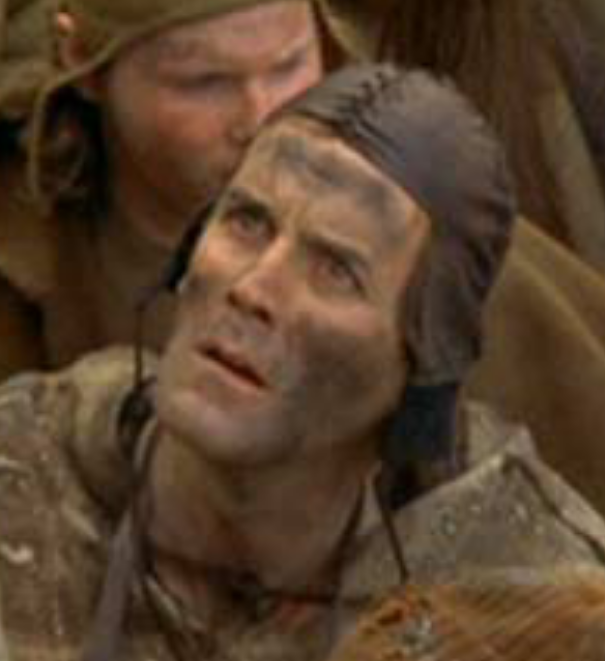

In [29]:
#im = Image.open(fnames[i]).convert('RGB')
#im = Image.open("D:\\imagenet2012\junco.jpg").convert('RGB')
im = Image.open("D:\\imagenet2012\john_cleese.png").convert('RGB')
#im = Image.open(fnames[np.argsort((y_val == 26))[-3]]).convert('RGB')
im

using model type: z

Original image predictions:
gyromitra (993): 0.12951360642910004
hartebeest (351): 0.10302609950304031
bloodhound, sleuthhound (163): 0.07946956157684326
Arabian camel, dromedary, Camelus dromedarius (354): 0.07580377906560898
potter's wheel (739): 0.035216543823480606

Generating adversarial example
L2: 0.0

Adversarial image predictions:
gyromitra (993): 0.12951360642910004
hartebeest (351): 0.10302609950304031
bloodhound, sleuthhound (163): 0.07946956157684326
Arabian camel, dromedary, Camelus dromedarius (354): 0.07580377906560898
potter's wheel (739): 0.035216543823480606


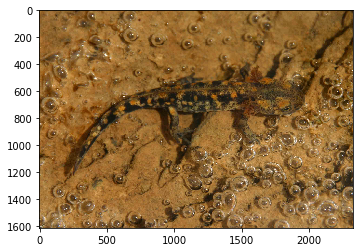

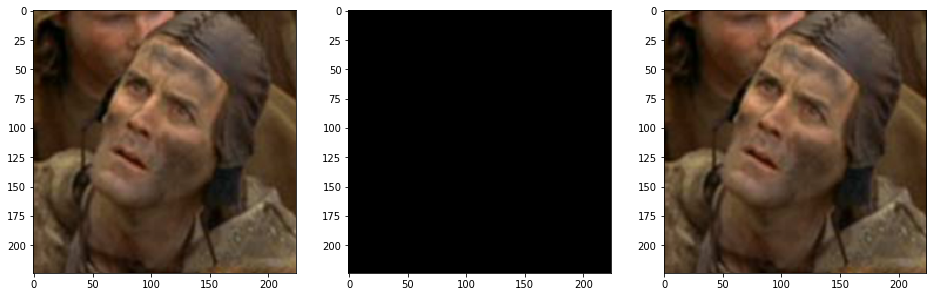

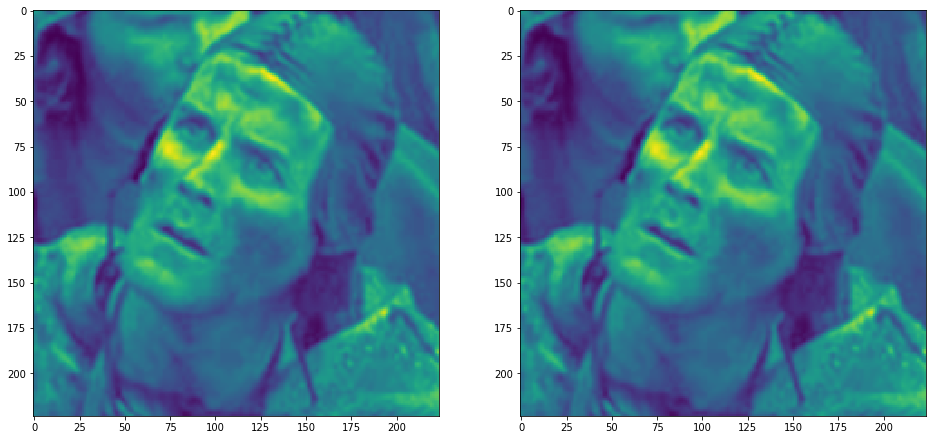

In [36]:
target_class=26 #lets turn him into a newt
perform_attack(im, 'z', target_class, True)

using model type: z

Original image predictions:
gyromitra (993): 0.12951360642910004
hartebeest (351): 0.10302609950304031
bloodhound, sleuthhound (163): 0.07946956157684326
Arabian camel, dromedary, Camelus dromedarius (354): 0.07580377906560898
potter's wheel (739): 0.035216543823480606

Generating adversarial example
L2: 77.64834

Adversarial image predictions:
common newt, Triturus vulgaris (26): 0.9999667406082153
dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk (319): 8.517778042005375e-06
African chameleon, Chamaeleo chamaeleon (47): 4.050193183502415e-06
barn spider, Araneus cavaticus (73): 2.8441525046218885e-06
grasshopper, hopper (311): 2.2789877220930066e-06


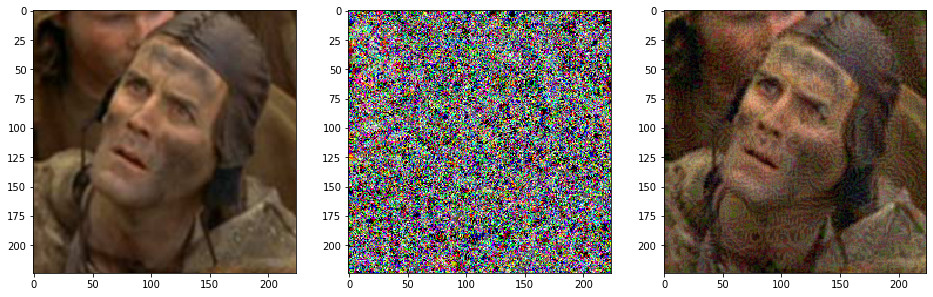

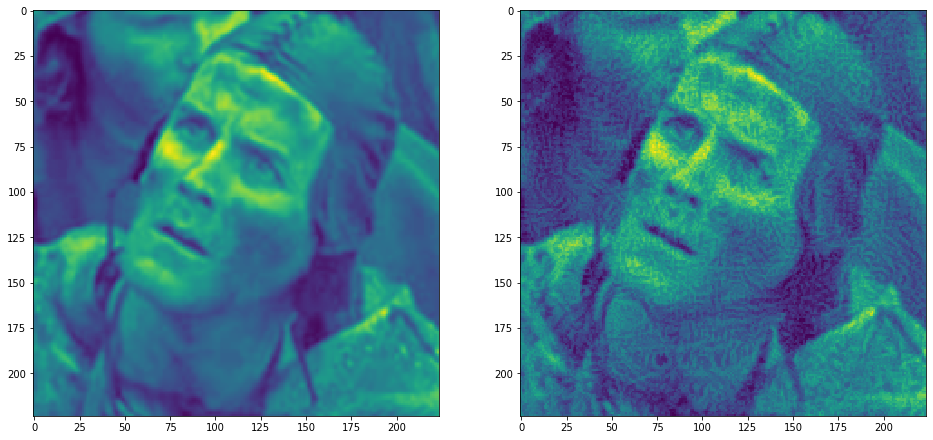

In [16]:
target_class=26 #lets turn him into a newt
perform_attack(im, 'z', target_class, True)

using model type: s

Original image predictions:
tobacco shop, tobacconist shop, tobacconist (860): 0.06681566685438156
military uniform (652): 0.06391838937997818
plastic bag (728): 0.03656125068664551
panpipe, pandean pipe, syrinx (699): 0.03420693054795265
academic gown, academic robe, judge's robe (400): 0.03127473220229149

Generating adversarial example
L2: 77.289536

Adversarial image predictions:
common newt, Triturus vulgaris (26): 0.9999473094940186
axolotl, mud puppy, Ambystoma mexicanum (29): 4.093971074325964e-05
eft (27): 1.0632060366333462e-05
scorpion (71): 4.5659913894269266e-07
spotted salamander, Ambystoma maculatum (28): 3.759932099001162e-07


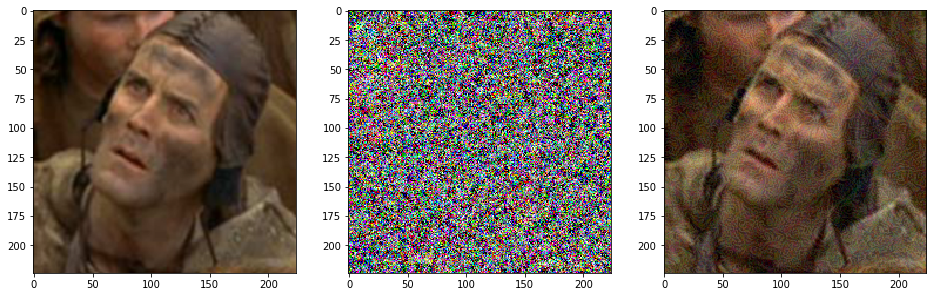

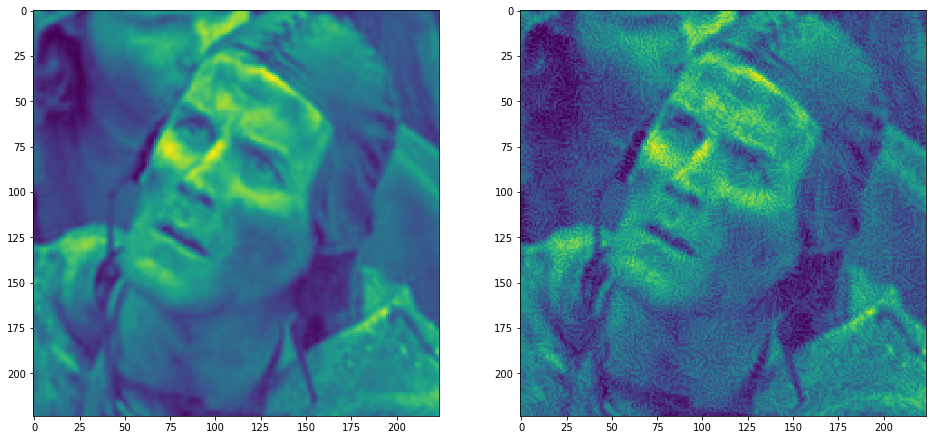

In [17]:
perform_attack(im, 's', target_class, True)

using model type: z

Original image predictions:
magpie (18): 0.9807124137878418
junco, snowbird (13): 0.008485633879899979
American coot, marsh hen, mud hen, water hen, Fulica americana (137): 0.006327349226921797
drake (97): 0.002436782931908965
coucal (91): 0.0003534578427206725

Generating adversarial example
L2: 78.49169

Adversarial image predictions:
great grey owl, great gray owl, Strix nebulosa (24): 0.9990537166595459
Appenzeller (240): 6.370397022692487e-05
boxer (242): 6.0109483456471935e-05
Rottweiler (234): 4.0081034967442974e-05
EntleBucher (241): 3.0979164876043797e-05


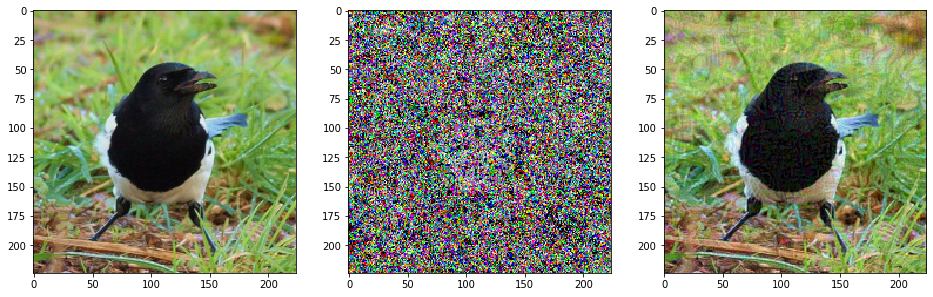

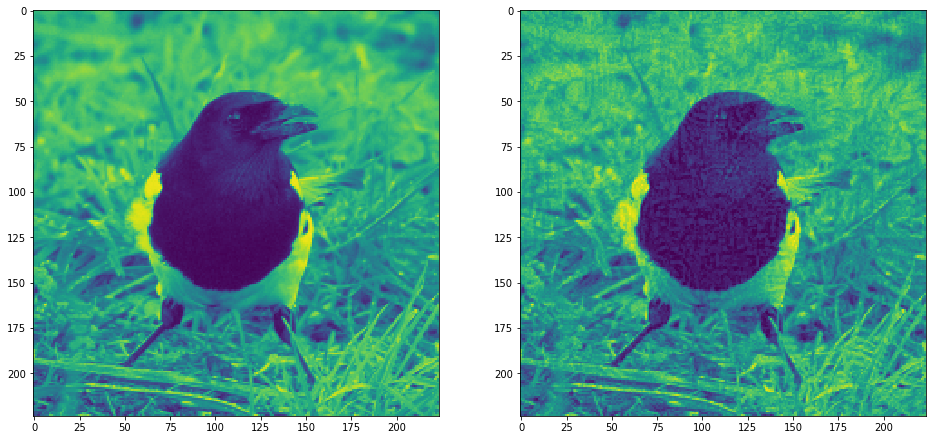

In [10]:
target_class = 24 #owl
perform_attack(im, 'z', target_class, True)

using model type: z

Original image predictions:
junco, snowbird (13): 0.8208329081535339
hornbill (93): 0.09115017205476761
bulbul (16): 0.07561135292053223
magpie (18): 0.002464961027726531
chickadee (19): 0.0017612366937100887

Generating adversarial example
L2: 82.06495

Adversarial image predictions:
great grey owl, great gray owl, Strix nebulosa (24): 0.9999483227729797
tricycle, trike, velocipede (870): 5.24218467035098e-06
Model T (661): 1.7306438166997395e-06
pug, pug-dog (254): 1.5848455632294645e-06
toilet seat (861): 1.5774147641423042e-06


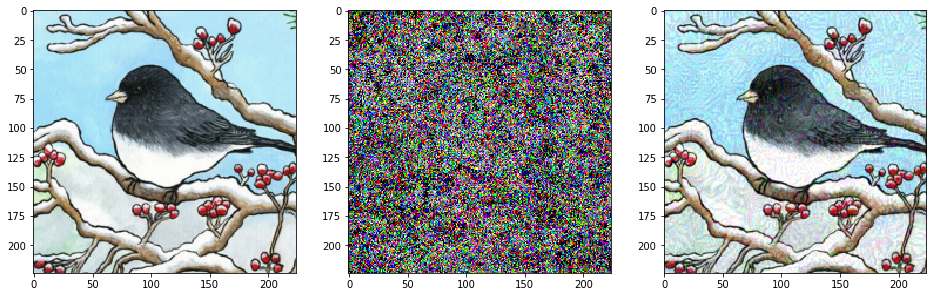

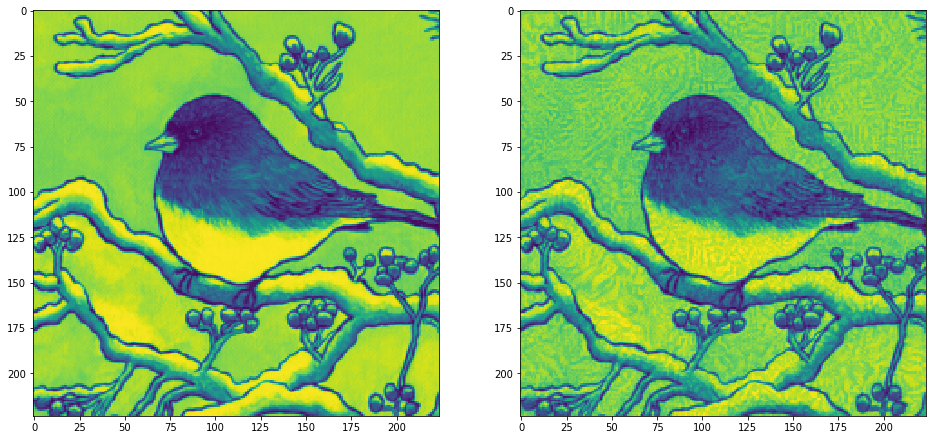

In [11]:
target_class = 24 #owl
im = Image.open("D:\\imagenet2012\junco.jpg").convert('RGB')
perform_attack(im, 'z', target_class, True)

using model type: s

Original image predictions:
junco, snowbird (13): 0.8199988603591919
prayer rug, prayer mat (741): 0.014861010946333408
handkerchief, hankie, hanky, hankey (591): 0.012516302056610584
robin, American robin, Turdus migratorius (15): 0.009601126424968243
tray (868): 0.008169511333107948

Generating adversarial example
L2: 79.51574

Adversarial image predictions:
great grey owl, great gray owl, Strix nebulosa (24): 0.9999991059303284
redshank, Tringa totanus (141): 2.6093246674463444e-07
robin, American robin, Turdus migratorius (15): 1.7707358779261995e-07
magpie (18): 1.6110422507153999e-07
kite (21): 8.275174678828989e-08


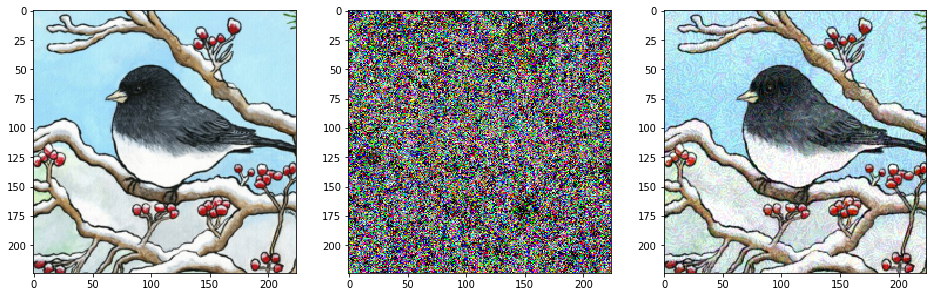

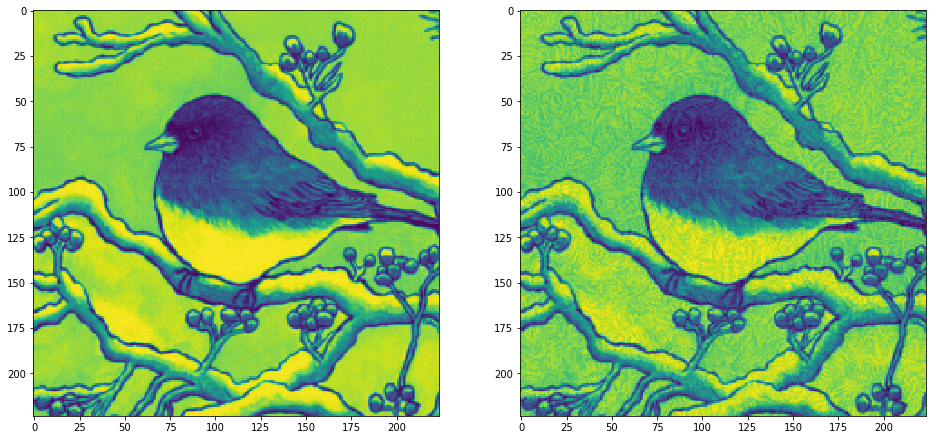

In [12]:
perform_attack(im, 's', target_class, True)

using model type: z

Original image predictions:
sandal (774): 0.1541583389043808
running shoe (770): 0.10500852018594742
clog, geta, patten, sabot (502): 0.05704495310783386
buckle (464): 0.056612420827150345
hatchet (596): 0.036182377487421036

Generating adversarial example
L2: 78.78746

Adversarial image predictions:
junco, snowbird (13): 0.7905837297439575
magpie (18): 0.006444868165999651
jay (17): 0.0046669733710587025
langur (374): 0.004286849871277809
chickadee (19): 0.0036147823557257652


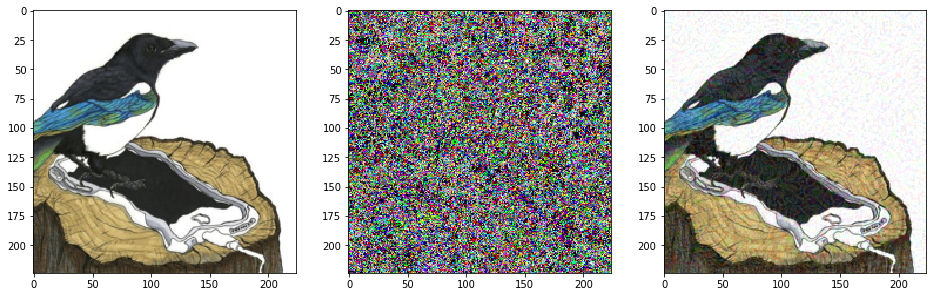

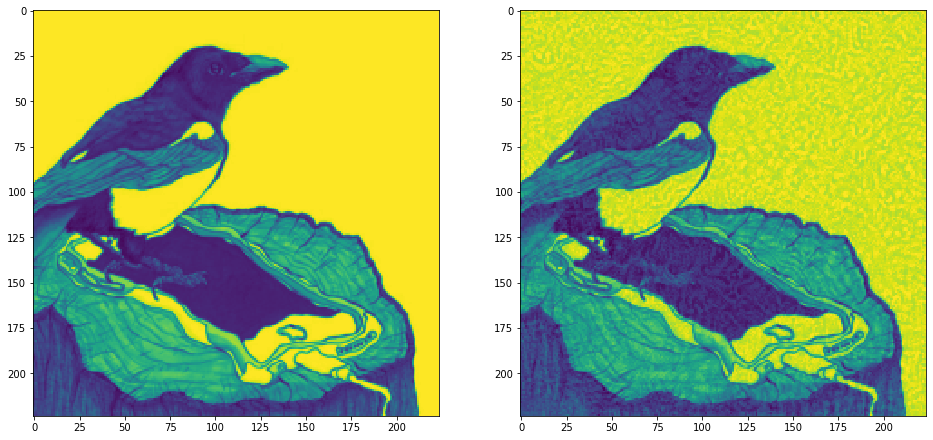

In [13]:
im = Image.open("D:\\imagenet2012\\magpie.jpg").convert('RGB')
perform_attack(im, 'z', 13, True)

using model type: s

Original image predictions:
zebra (340): 0.9992734789848328
gazelle (353): 0.0004376759461592883
impala, Aepyceros melampus (352): 0.0001238221739185974
hartebeest (351): 4.764332697959617e-05
lionfish (396): 2.8963519071112387e-05

Generating adversarial example
L2: 76.57732

Adversarial image predictions:
zebra (340): 0.7267922759056091
tiger cat (282): 0.041500918567180634
chainlink fence (489): 0.01820881851017475
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus (323): 0.008610371500253677
knot (616): 0.006135208066552877


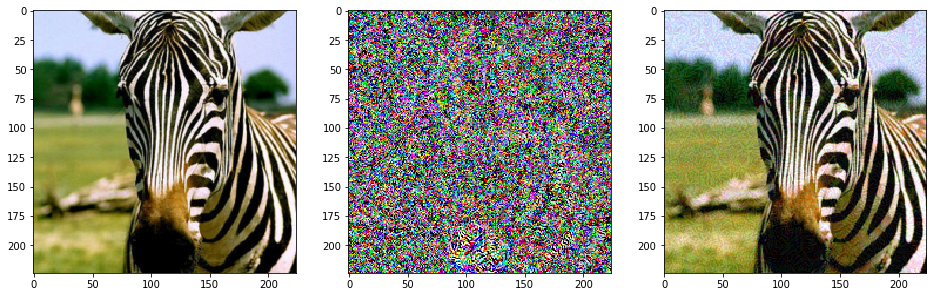

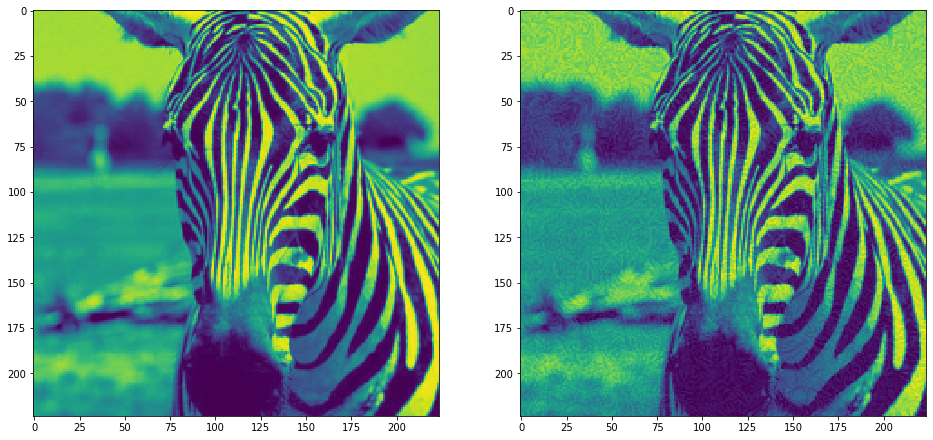

In [17]:
im = Image.open(fnames[28479]).convert('RGB')
perform_attack(im, 's', 625, True)

ox
hamster
Adversarial image at step 0. L2 error 0.0 and class label 333.


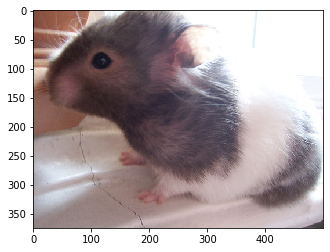

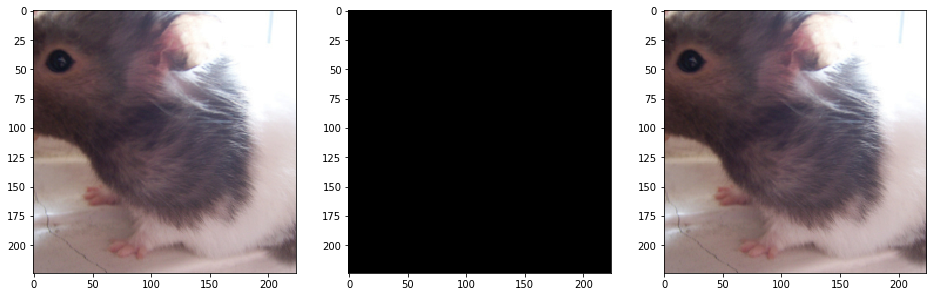

Adversarial image at step 500. L2 error 0.0 and class label 333.


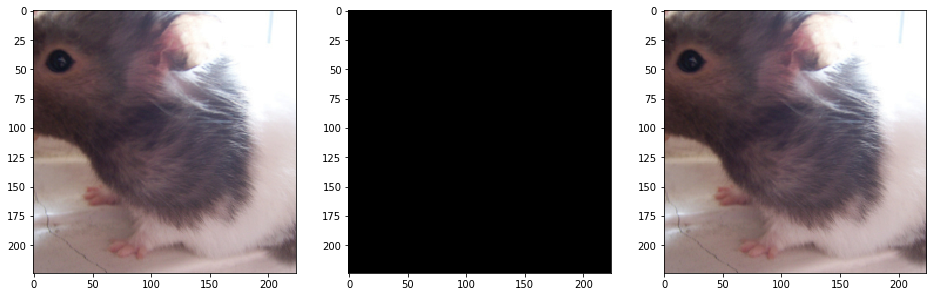

Adversarial image at step 1000. L2 error 0.0 and class label 333.


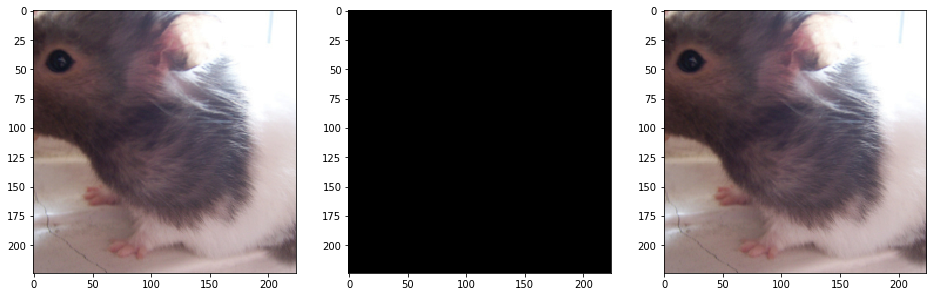

Adversarial image at step 1500. L2 error 0.0 and class label 333.


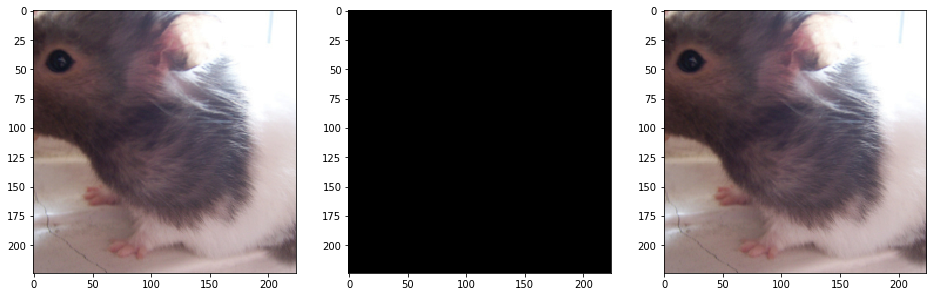

Adversarial image at step 2000. L2 error 0.0 and class label 333.


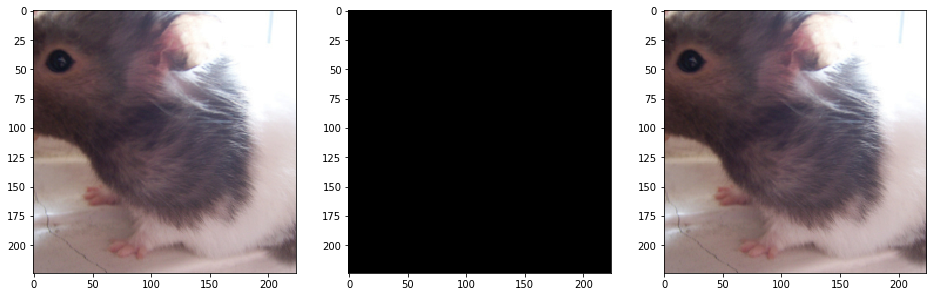

Adversarial image at step 2500. L2 error 0.0 and class label 333.


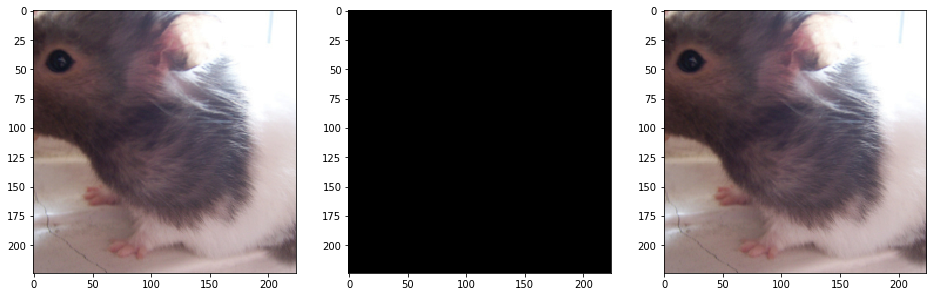

Adversarial image at step 3000. L2 error 0.0 and class label 333.


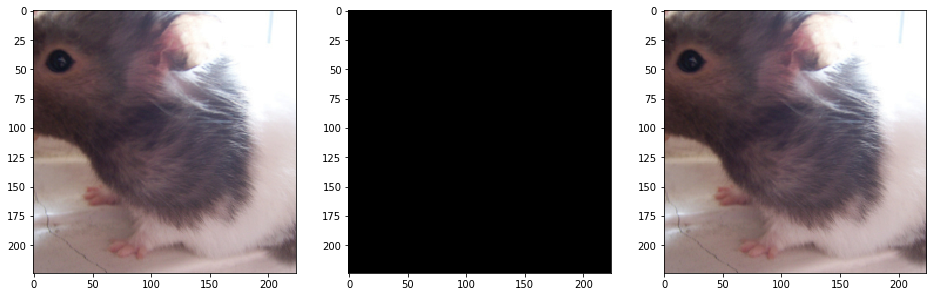

Adversarial image at step 3500. L2 error 0.0 and class label 333.


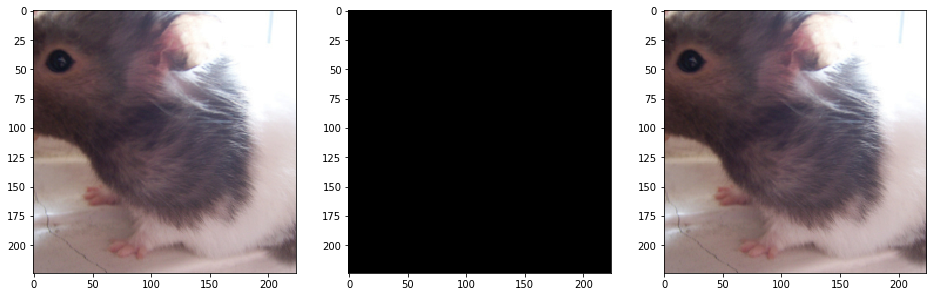

Adversarial image at step 4000. L2 error 0.0 and class label 333.


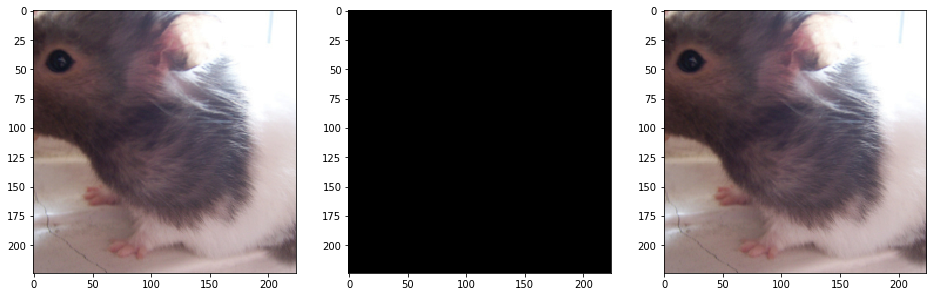

Adversarial image at step 4500. L2 error 0.0 and class label 333.


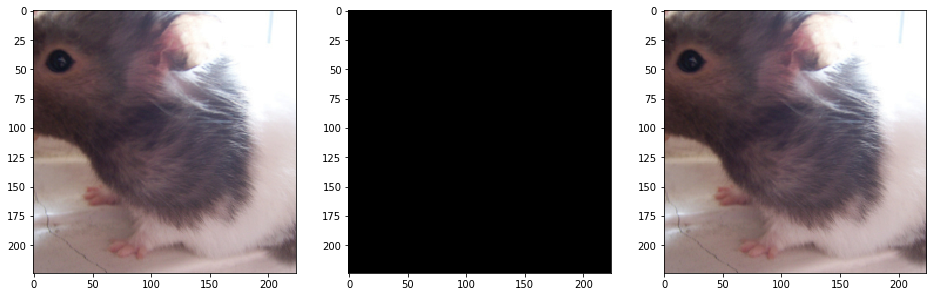

In [59]:
import logging
logging.basicConfig(level=logging.INFO)


from art.utils import to_categorical
model = get_model('z')
model.eval()
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


classifier = PyTorchClassifier(model=model, loss=criterion,
                               optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
#attack = BoundaryAttack(classifier=classifier, targeted=True, max_iter=0, max_eval=1000, init_eval=10)
attack = BoundaryAttack(classifier=classifier, targeted=True, max_iter=0, delta=0.0005, epsilon=0.0005)
iter_step = 500 

src_class = 345
target_class = 333
print(labels[src_class])
print(labels[target_class])

init_image = get_image_by_class(src_class)
target_image = get_image_by_class(target_class)

plt.imshow(target_image)

x_init =  transform(target_image).unsqueeze(0).numpy()
x_adv_init = transform(init_image).unsqueeze(0).numpy()

for i in range(10):
    x_adv = attack.generate(x=x_init, y=np.array([src_class]), x_adv_init=x_adv_init)
    
    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - x_init[0], [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    
    original_image = np.moveaxis(unnormalize(torch.from_numpy(x_init[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    adv_image = np.moveaxis(unnormalize(torch.from_numpy(x_adv[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    pert = np.abs(adv_image - original_image)[..., ::-1]
    pert_min = np.min(pert)
    pert_max = np.max(pert)
    pert_image = -((pert - pert_min) / (pert_max - pert_min))+1

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    axes[0].imshow(original_image)
    axes[1].imshow(pert_image)
    axes[2].imshow(adv_image)
    plt.show(block=False)
    
    attack.max_iter = iter_step